# Classifying Unpaywall Locations - Sample Analysis

In this notebook, I will take a look at a sample of a dataset that examines and classifies the various locations at which a scientific article is available. The articles´ location information is taken from the Unpaywall database and classified again more precisely. In this context, repository evidence in OpenDOAR was particular determined.

The structure of this analysis looks like this: Firstly, the correctness of the specified `oa_category` values is checked. For this purpose, in addition to ancillary information from Unpaywall such as DOIs or evidence types, stored URLs are cross-checked and compared with possible entries in OpenDOAR. The sample table contains three further columns which are `evaluation`, `revision` and `comment`. The `evaluation` column contains a logical value and indicates whether the classification is correct or not. Once a classification is not correct, the corrected value is entered in the revision column. In addition, a comment is also given in the respective comment column. Then the actual evaluation of the findings takes place. For that, I compute the accuracy of the classification and point out common errors.

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.ticker import MaxNLocator
import seaborn as sns
import numpy as np
from sklearn.metrics import accuracy_score
import networkx as nx

In [2]:
sns.set_style('whitegrid')

In [3]:
df = pd.read_csv('sample_manual_check.csv', sep=';')

In [4]:
df.head()

,upw_doi,oa_category,evidence,host_type,repository_institution,url_for_landing_page,url_for_pdf,evaluation,revision,comment
0,10.4014/jmb.1406.06025,other_repo,oa repository (semantic scholar lookup),repository,NaN,https://semanticscholar.org/paper/825288712308...,http://pdfs.semanticscholar.org/8252/887123083...,True,NaN,NaN
1,10.1017/s095252381300045x,other_oa_journal,open (via page says Open Access),publisher,NaN,https://doi.org/10.1017/s095252381300045x,https://www.cambridge.org/core/services/aop-ca...,True,NaN,NaN
2,10.1017/s095252381300045x,other_repo,oa repository (via pmcid lookup),repository,NaN,https://www.ncbi.nlm.nih.gov/pmc/articles/PMC4...,NaN,True,NaN,NaN
3,10.1017/s095252381300045x,opendoar_subject,oa repository (via OAI-PMH doi match),repository,pubmedcentral.nih.gov,http://europepmc.org/articles/pmc4131156,http://europepmc.org/articles/pmc4131156?pdf=r...,True,NaN,NaN
4,10.1017/s095252381300045x,other_repo,oa repository (semantic scholar lookup),repository,NaN,https://semanticscholar.org/paper/156818d2a1e3...,http://pdfs.semanticscholar.org/1c3b/41421f34b...,True,NaN,NaN


In [5]:
accuracy_score([1] * len(df.evaluation), df.evaluation)

0.9036144578313253

The accuracy of classifications determined in this sample amounts to approximately 90%. In the next step, the incorrectly classified locations are examined in more detail.

In [6]:
df_false = df[df.evaluation == False]

In [7]:
df_false.groupby(['upw_doi'])['evaluation'].count()

upw_doi
10.1002/2015pa002792            1
10.1016/j.beproc.2013.10.007    1
10.1016/j.ccell.2017.03.001     7
10.1051/0004-6361/201832888     4
10.1103/physrevd.84.052011      3
10.1111/1365-2664.12915         1
10.1534/genetics.117.300421     1
10.3842/sigma.2018.104          3
10.3897/dez.63.10799            1
10.4056/sigs.3117229            1
10.5301/jabfm.2013.10832        1
Name: evaluation, dtype: int64

In [8]:
df_false.describe()

,upw_doi,oa_category,evidence,host_type,repository_institution,url_for_landing_page,url_for_pdf,evaluation,revision,comment
count,24,24,22,22,20,21,16,24,24,22
unique,11,4,3,1,12,21,16,1,6,15
top,10.1016/j.ccell.2017.03.001,other_repo,oa repository (via OAI-PMH doi match),repository,Max Planck Society - MPG.PuRe,http://hdl.handle.net/11858/00-001M-0000-002D-...,http://hdl.handle.net/11858/00-001M-0000-002D-...,False,opendoar_other,https://v2.sherpa.ac.uk/id/repository/1874
freq,7,18,11,22,6,1,1,24,14,3


In this sample, 11% of articles have at least one faulty connection to a location. Overall, about 10% of the locations are classified incorrectly.

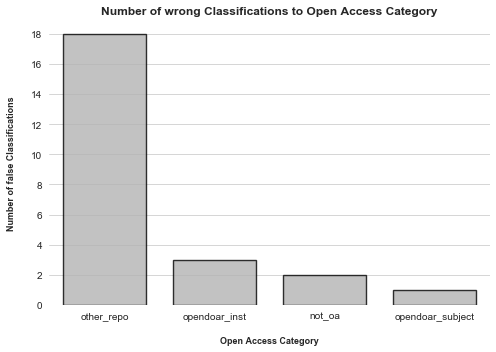

In [9]:
df_false_evaluation = df_false['oa_category'].value_counts().reset_index()
df_false_evaluation.columns = ['oa_category', 'number_of_wrong_categorizations']

fig, axes = plt.subplots(figsize=(7,5))

ax = sns.barplot(x='oa_category',
                 y='number_of_wrong_categorizations',
                 data=df_false_evaluation,
                 color='#b3b3b3a0',
                 alpha=0.8,
                 linewidth=1.4,
                 edgecolor='black')

for bar in ax.patches:
    x = bar.get_x()
    width = bar.get_width()
    bar.set_x(x + width/2 - 0.75/2)
    bar.set_width(0.75)

ax.yaxis.set_major_locator(MaxNLocator(integer=True))

plt.title('Number of wrong Classifications to Open Access Category',
          fontsize=12, fontweight=700)

plt.xlabel('Open Access Category', 
           labelpad=15, fontsize=9, fontweight=600)

plt.ylabel('Number of false Classifications', 
           labelpad=15, fontsize=9, fontweight=600)

plt.box(False)

plt.tight_layout()

plt.show()

As can be seen, by far most of the locations that were incorrectly recognized have been classified as `other_repo`. In addition, incorrect classifications were found in the groups `opendoar_inst`, `not_oa` and `opendoar_subject`. In three cases, the allocation of evidence types of an article by Unpaywall was incorrect. In one of these cases, the location of an article was mistakenly classified as a repository, but turned out to be an open access journal (see [Link](https://www.aanda.org/)). In two other cases, alleged closed access articles were openly available. Further, classification errors with this [repository](https://pure.mpg.de/) were particularly frequently. This repository was often recognized as `other_repo` but is available in OpenDOAR ([Link](https://v2.sherpa.ac.uk/id/repository/1874)). Various other problems also occurred in connection with this repository. For instance, additional material such as Excel spreadsheets were associated with the specified URL in the dataset sample. In other cases, different versions of an article were available. Besides that, also locations that are available through the same domain are being recognized several times differently, but are classified uniformly in OpenDOAR. See [zenodo](https://v2.sherpa.ac.uk/id/repository/2659).

In [10]:
df[df.url_for_landing_page.str.contains('zenodo', na=False)]

,upw_doi,oa_category,evidence,host_type,repository_institution,url_for_landing_page,url_for_pdf,evaluation,revision,comment
234,10.3897/dez.63.10799,opendoar_other,oa repository (via OAI-PMH title and first aut...,repository,CERN European Organization for Nuclear Researc...,https://zenodo.org/record/168551,https://zenodo.org/record/168551/files/DEZ_art...,True,NaN,NaN
235,10.3897/dez.63.10799,opendoar_inst,oa repository (via OAI-PMH title and first aut...,repository,CERN European Organization for Nuclear Researc...,https://zenodo.org/record/168551,https://zenodo.org/record/168551/files/DEZ_art...,False,opendoar_other,https://v2.sherpa.ac.uk/id/repository/2659


In the next step, the distribution of the revised categories will be examined.

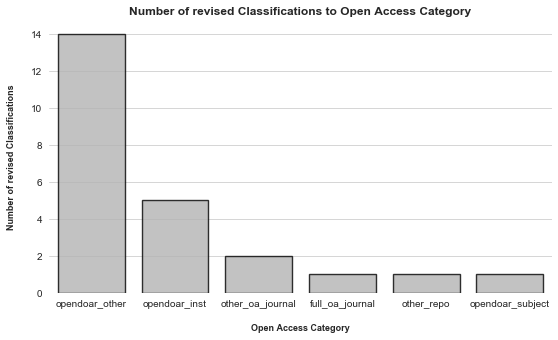

In [11]:
df_false_revision = df_false['revision'].value_counts().reset_index()
df_false_revision.columns = ['oa_category', 'number_of_revised_categorizations']

fig, axes = plt.subplots(figsize=(9,5))

ax = sns.barplot(x='oa_category',
                 y='number_of_revised_categorizations',
                 data=df_false_revision,
                 alpha=0.8,
                 linewidth=1.4,
                 color='#b3b3b3a0',
                 edgecolor='black')

ax.yaxis.set_major_locator(MaxNLocator(integer=True))

plt.title('Number of revised Classifications to Open Access Category',
          fontsize=12, fontweight=700)

plt.xlabel('Open Access Category', 
           labelpad=15, fontsize=9, fontweight=600)

plt.ylabel('Number of revised Classifications', 
           labelpad=15, fontsize=9, fontweight=600)

plt.box(False)

plt.show()

In most cases, repositories were not associated with OpenDOAR, although there is an entry. Interestingly, incorrect locations were often not recognized as `opendoar_other`. For a few cases, `opendoar_inst` was also not classified correctly. These were often recognized as `other_repo`. In one case, no connection to OpenDOAR could be proven and was therefore noted as `other_repo`. However, there may be an entry for this repository in OpenDOAR. The repository is located [here](http://www.vliz.be).

In order to visualize the revision in more detail, I will present the results using a network. The nodes represent locations (incorrect as well as revised) and the edges point to the corrected location. The edges are weighted according to their frequency. The weighting was normalized by the average value of the weights. 

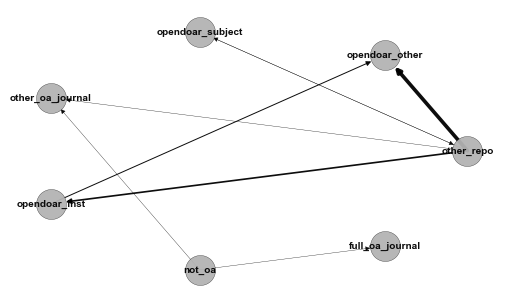

In [12]:
fig = plt.figure(figsize=(7,4))

df_false_edges = df_false.agg(lambda x: tuple([x['oa_category'], x['revision']]), 
                                      axis=1).values

G = nx.DiGraph()
G.add_edges_from(df_false_edges)

for u, v, d in G.edges(data=True):
    weight = list(df_false_edges).count(tuple([u, v]))
    G[u][v]['weight'] = weight
    
edgewidth = [d['weight'] for (u, v, d) in G.edges(data = True)]
edgewidth = [w / np.mean(edgewidth) for w in edgewidth]

pos = nx.circular_layout(G)

nx.draw(G, 
        pos=pos, 
        width=edgewidth, 
        with_labels=True, 
        node_size=900,
        linewidths=0.3,
        alpha=0.95,
        node_color='#b3b3b3',
        font_size=10, 
        font_weight='bold')

ax = plt.gca() 
ax.collections[0].set_edgecolor('black')

plt.show()

`opendoar_other` in particular was often incorrectly recognized as `other_repo`. In addition, entries from repositories classified as `other_repo` were verified in OpenDOAR as institutional repositories. The two cases, which were incorrectly recognized as closed access, split into `other_oa_journal` and `full_oa_journal` after the revision.